### Plan de ce notebook

1. Use pre-trained GloVe words for embeddings
2. Use pre-trained word2vec words for embeddings
3. What about Freebase ?
4. Use pre-trained GloVe words for embeddings with LSTM model

pour standardiser le nom des variables: GloVe _stanford et word2vec _google ?

# Nettoyage et conversion numérique des données

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPooling1D, Bidirectional, Conv1D, concatenate
from keras.models import Model

from tools import *
import numpy as np

Using TensorFlow backend.


In [2]:
# load raw string data
data_train, y_train_all, data_test, id_test = load_data()

## Nettoyage des données (optionnel)

In [3]:
params = {'lower': True, 
          'lemma': False, 
          'stop_words': False}

comment = data_train[2]
print(comment)
print('-------')
print(clean_comment(comment, **params))

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
-------
hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info 


In [4]:
clean_data_train = transform_dataset(data_train, func=clean_comment, kwargs=params)
clean_data_test = transform_dataset(data_test, func=clean_comment, kwargs=params)

Transformation: 100%       
Transformation: 100%       


## Tokenization et découpage des données textuelles 

Conforme au github https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb

pour pouvoir encode avec Glove après (ne pas encode directement != Nicolas sur models_testing.ipynb)

In [5]:
# Convert strings to int indexes, 
# considering only the VOCAB_SIZE most commons words, 
# and pad the sentences to SENTENCE_LENGTH words
VOCAB_SIZE = 30000
SENTENCE_LENGTH = 200  # 200 if stop_words deleted, 120 otherwise

In [6]:
tokenizer = TokenVectorizer(max_len=SENTENCE_LENGTH, max_features=VOCAB_SIZE)

# X_train_all, X_test = encode(data_train, data_test, vectorizer=tokens_vectorizer)
X_train_all, X_test = encode(clean_data_train, clean_data_test, vectorizer=tokenizer)

ENCODING: Fitting vectorizer to data
ENCODING: transforming data to numerical


In [7]:
SPLIT_VALID_RATIO = 0.10
SPLIT_RANDOM_SEED = 0  # TODO : check split because of unbalanced classes

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=SPLIT_VALID_RATIO,
                                                      random_state=SPLIT_RANDOM_SEED)

# 1. Use pre-trained GloVe words for embeddings

https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

https://github.com/msahamed/yelp_comments_classification_nlp

https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb

## embedding_matrix avec les embeddings de Glove

several possibilities of pre-training/embeddings vector sizes for GloVe, see:

https://nlp.stanford.edu/projects/glove/

dans Mikolov c'est du 300 pour la taille des embeddings https://code.google.com/archive/p/word2vec/

In [24]:
# Load GloVe pre-trained embeddings
EMBEDDING_DIM = 200  # several embeddings sizes possible with Glove : 50, 100, 200, 300 
GLOVE_EMBEDDINGS = 'glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)

embeddings_index = dict()
with open(GLOVE_EMBEDDINGS) as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        #print(coefs.shape) # le code est bien compatible avec le format renvoyé par word2vec
        embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [25]:
# Create a weight matrix for words in training docs

# get mean and std values of pre-trained embeddings
all_embs = np.stack(embeddings_index.values())
# print(all_embs.shape)
emb_mean, emb_std = np.mean(all_embs, axis=0), np.std(all_embs, axis=0)
# print(emb_mean)
# print(emb_std) # les prints sont là pour évaluer comment faire l'initialisation arbitraire pour word2vec

# init matrix to embeddings distribution
embedding_matrix = np.random.normal(emb_mean, emb_std, (VOCAB_SIZE, EMBEDDING_DIM))
# print(embedding_matrix)

In [26]:
# loop on words in our documents

wordWithGloveEmb = 0

for word, index in tokenizer.word_index.items():
    # if word isn't enough used in documents, ignore it
    if index >= VOCAB_SIZE: 
        continue
    # otherwise, fill embedding matrix with pre-trained vector corresponding to this word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        wordWithGloveEmb += 1
        embedding_matrix[index, :] = embedding_vector
        
print("Number of words with a GloVe embedding:",wordWithGloveEmb)
print("Percentage of words with a GloVe embedding:",wordWithGloveEmb/VOCAB_SIZE)

Number of words with a GloVe embedding: 27288
Percentage of words with a GloVe embedding: 0.9096


## Définition du réseau de Yoon Kim pour GloVe

In [27]:
N_FILTERS = 100
MODEL_NAME = "embed_conv_fc_GLOVE200t"

# input
inp = Input(shape=(SENTENCE_LENGTH, ))
# embedding
emb = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SENTENCE_LENGTH, 
                weights=[embedding_matrix], trainable=True)(inp)

# Specify each convolution layer and their kernel siz i.e. n-grams 
conv_3 = Conv1D(filters=N_FILTERS, kernel_size=3, activation='relu')(emb)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(filters=N_FILTERS, kernel_size=4, activation='relu')(emb)
pool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(filters=N_FILTERS, kernel_size=5, activation='relu')(emb)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Gather all convolution layers
x = concatenate([pool_3, pool_4, pool_5], axis=1)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
outp = Dense(6, activation='sigmoid')(x)

# # load pre-trained model from disk
# model = load_nnet(MODEL_NAME)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1309s 9ms/step - loss: 0.0558 - acc: 0.9796 - val_loss: 0.0432 - val_acc: 0.9835
epoch: 1 - val_roc_auc: 0.9856
Epoch 2/2
143613/143613 [==============================] - 1287s 9ms/step - loss: 0.0411 - acc: 0.9837 - val_loss: 0.0450 - val_acc: 0.9828
epoch: 2 - val_roc_auc: 0.9868


In [29]:
# save trained nnet to disk for later use
save_nnet(model, MODEL_NAME)

In [30]:
# final model evaluation
y_train_pred = model.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 

y_valid_pred = model.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9940
ROC-AUC score on validation set : 0.9868


In [31]:
# predict
y_test_pred = model.predict(X_test, batch_size=512, verbose=2)

In [32]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME)

# 2. Use pre-trained word2vec words for embeddings

le github précédent utilise word2vec pour entraîner sur le corpus du problème même, et pas comme source d'embeddings pré entraînés... https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb

"In this subsection, I use word2vec to create word embeddings from the review comments. Word2vec is one algorithm for learning a word embedding from a text corpus." --->>> à la base word2vec c'est le réseau d'extraction, on veut récupérer un résultat d'entraînement de référence de cette architecture !

Il faut utiliser word2vec entraîné sur Google News, embeddings de taille 300, par Mikolov https://code.google.com/archive/p/word2vec/

Post de blog chargeant word2vec pré-entraîné par Mikolov:

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Lien de téléchargement des embeddings pré entraînés:

https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [1]:
from gensim.models import KeyedVectors

filename = 'GoogleNews-vectors-negative300.bin/data'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [2]:
google_model_words = list(google_model.wv.vocab)
print("Number of words in pre trained word2vec:",len(google_model_words))

Number of words in pre trained word2vec: 3000000


/home/mbauw/Documents/Académique/M2_AIC/OPT1_DataCamp/mars_craters/mars_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [14]:
print(type(google_model['fuck']))

<class 'numpy.ndarray'>


In [15]:
google_model['fuck'].shape

(300,)

In [16]:
len(google_model_words)

3000000

In [17]:
google_model_words[2]

'Viviene'

In [40]:
# google_mode is "Word2VecKeyedVectors" type

google_model_complete_emb = google_model.wv
print(google_model_complete_emb)

/home/mbauw/Documents/Académique/M2_AIC/OPT1_DataCamp/mars_craters/mars_env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


## embedding_matrix avec les embeddings de google news word2vec

- notons que le tokenizer est déjà initialisé et reste le même

- à la différence de ce qu'on a fait avec GloVe, on ne parvient pas à initialiser la matrice à partir des caractéristiques statistiques des embeddings pré entraînés, <font color='red'> pas assez de RAM </font> pour faire les calculs et stocker toutes ces matrices visiblement... (cf. les <font color='red'> deux blocs totalement commentés </font>)

In [3]:
# Constantes inchangées:
# VOCAB_SIZE = 30000
# SENTENCE_LENGTH = 200  # 200 if stop_words deleted, 120 otherwise

# ONLY ONE embedding size possible with google news trained word2vec
EMBEDDING_DIM_GOOGLE = 300

In [4]:
# Convert strings to int indexes, 
# considering only the VOCAB_SIZE most commons words, 
# and pad the sentences to SENTENCE_LENGTH words
VOCAB_SIZE = 30000
SENTENCE_LENGTH = 200  # 200 if stop_words deleted, 120 otherwise

In [5]:
embeddings_index_google = dict()
for googleRetainedWord in google_model_words:
    embeddings_index_google[googleRetainedWord] = google_model[googleRetainedWord]
print('Loaded %s word vectors.' % len(embeddings_index_google))

Loaded 3000000 word vectors.


In [10]:
type(google_model)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [6]:
# %xdel google_model
del google_model

In [10]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [9]:
## Doesn't work: NOT ENOUGH RAM TO CREATE STATISTICALLY COHERENT INITIALIZATION

# # Create a weight matrix for words in training docs

# get mean and std values of pre-trained embeddings
all_embs_google = np.stack(embeddings_index_google.values())
emb_mean_google, emb_std_google = np.mean(all_embs_google, axis=0), \
                                    np.std(all_embs_google, axis=0)

In [10]:
del all_embs_google

# init matrix to embeddings distribution
embedding_matrix_google = np.random.normal(emb_mean_google, emb_std_google,\
                                           (VOCAB_SIZE, EMBEDDING_DIM_GOOGLE))

# In case of emergency...
# embedding_matrix_google = np.random.normal(0, 1, (VOCAB_SIZE, EMBEDDING_DIM_GOOGLE))

In [12]:
# save word2vec pretrained embeddings initialized matrix to .csv to avoid
# RAM killing computations
np.save('./data/init_embedding_matrix_google',embedding_matrix_google)

In [13]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPooling1D, Bidirectional, Conv1D, concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer

In [14]:
# load raw string data
data_train, y_train_all, data_test, id_test = load_data()

In [16]:
params = {'lower': True, 
          'lemma': False, 
          'stop_words': False}

clean_data_train = transform_dataset(data_train, func=clean_comment, kwargs=params)
clean_data_test = transform_dataset(data_test, func=clean_comment, kwargs=params)

Transformation: 100%       
Transformation: 100%       


In [17]:
tokenizer = TokenVectorizer(max_len=SENTENCE_LENGTH, max_features=VOCAB_SIZE)

# X_train_all, X_test = encode(data_train, data_test, vectorizer=tokens_vectorizer)
X_train_all, X_test = encode(clean_data_train, clean_data_test, vectorizer=tokenizer)

ENCODING: Fitting vectorizer to data
ENCODING: transforming data to numerical


In [18]:
SPLIT_VALID_RATIO = 0.10
SPLIT_RANDOM_SEED = 0  # TODO : check split because of unbalanced classes

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=SPLIT_VALID_RATIO,
                                                      random_state=SPLIT_RANDOM_SEED)

In [20]:
# update weight matrix for words in training docs

wordWithGoogleEmb = 0

for word, index in tokenizer.word_index.items():
    if index > VOCAB_SIZE - 1: # détermine à quel point on s'intéresse aux mots moins importants d'après Glove
        continue
    else:
        try:
            embedding_vector_google = embeddings_index_google[word] # on va chercher le mot dans word2vec embeddings
        except KeyError:
            embedding_vector_google = None
        if embedding_vector_google is not None:
            wordWithGoogleEmb += 1
            embedding_matrix_google[index,:] = embedding_vector_google

print("Number of words with a word2vec embedding:",wordWithGoogleEmb)
print("Percentage of words with a word2vec embedding:",wordWithGoogleEmb/VOCAB_SIZE)

Number of words with a word2vec embedding: 24533
Percentage of words with a word2vec embedding: 0.8177666666666666


In [21]:
print(embedding_matrix_google.shape)

(30000, 300)


## Définition du réseau de Yoon Kim pour word2vec

In [22]:
N_FILTERS = 100
MODEL_NAME_GOOGLE = "embed_conv_fc_GOOGLE"

# input
inp = Input(shape=(SENTENCE_LENGTH, ))
# embedding
emb = Embedding(VOCAB_SIZE, EMBEDDING_DIM_GOOGLE,input_length=SENTENCE_LENGTH,weights=[embedding_matrix_google], trainable=False)(inp)

# Specify each convolution layer and their kernel siz i.e. n-grams 
conv_3 = Conv1D(filters=N_FILTERS, kernel_size=3, activation='relu')(emb)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(filters=N_FILTERS, kernel_size=4, activation='relu')(emb)
pool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(filters=N_FILTERS, kernel_size=5, activation='relu')(emb)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Gather all convolution layers
x = concatenate([pool_3, pool_4, pool_5], axis=1)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
outp = Dense(6, activation='sigmoid')(x)

# # load pre-trained model from disk
# model = load_nnet(MODEL_NAME)

model_google = Model(inputs=inp, outputs=outp)
model_google.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model_google.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1107s 8ms/step - loss: 0.0554 - acc: 0.9798 - val_loss: 0.0458 - val_acc: 0.9826
epoch: 1 - val_roc_auc: 0.9857
Epoch 2/2
143613/143613 [==============================] - 1086s 8ms/step - loss: 0.0445 - acc: 0.9829 - val_loss: 0.0442 - val_acc: 0.9830
epoch: 2 - val_roc_auc: 0.9867


In [24]:
# save trained nnet to disk for later use
save_nnet(model_google, MODEL_NAME_GOOGLE)

In [25]:
# final model evaluation
y_train_pred = model_google.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 

y_valid_pred = model_google.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9921
ROC-AUC score on validation set : 0.9867


In [26]:
# predict
y_test_pred = model_google.predict(X_test, batch_size=512, verbose=2)

In [27]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME_GOOGLE)

### Training plots

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[0.9797847805416449, 0.9829158790570754]


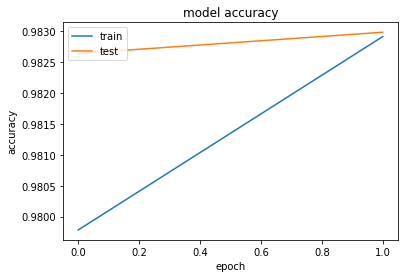

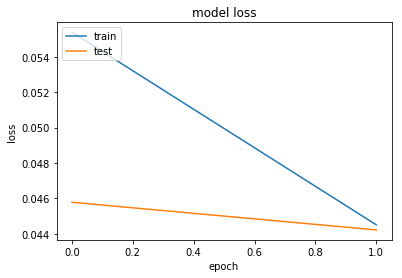

In [31]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
print(hist.history['acc'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3. What about Freebase ?

https://code.google.com/archive/p/word2vec/

# 4. Use pre-trained GloVe words for embeddings with LSTM model

## embedding_matrix avec les embeddings de Glove

copy of code above

In [8]:
# Load GloVe pre-trained embeddings
EMBEDDING_DIM = 200  # several embeddings sizes possible with Glove : 50, 100, 200, 300 
GLOVE_EMBEDDINGS = 'glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)

embeddings_index = dict()
with open(GLOVE_EMBEDDINGS) as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        #print(coefs.shape) # le code est bien compatible avec le format renvoyé par word2vec
        embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [9]:
# Create a weight matrix for words in training docs

# get mean and std values of pre-trained embeddings
all_embs = np.stack(embeddings_index.values())
# print(all_embs.shape)
emb_mean, emb_std = np.mean(all_embs, axis=0), np.std(all_embs, axis=0)
# print(emb_mean)
# print(emb_std) # les prints sont là pour évaluer comment faire l'initialisation arbitraire pour word2vec

# init matrix to embeddings distribution
embedding_matrix = np.random.normal(emb_mean, emb_std, (VOCAB_SIZE, EMBEDDING_DIM))
# print(embedding_matrix)

In [10]:
# loop on words in our documents

wordWithGloveEmb = 0

for word, index in tokenizer.word_index.items():
    # if word isn't enough used in documents, ignore it
    if index >= VOCAB_SIZE: 
        continue
    # otherwise, fill embedding matrix with pre-trained vector corresponding to this word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        wordWithGloveEmb += 1
        embedding_matrix[index, :] = embedding_vector
        
print("Number of words with a GloVe embedding:",wordWithGloveEmb)
print("Percentage of words with a GloVe embedding:",wordWithGloveEmb/VOCAB_SIZE)

Number of words with a GloVe embedding: 27288
Percentage of words with a GloVe embedding: 0.9096


## Définition du réseau LSTM pour GloVe

In [11]:
MODEL_NAME = "draft_embed_bidirlstm_2fc_EMB_PRETRAINED_GLOVE200t"

# input
inp = Input(shape=(SENTENCE_LENGTH, ))
# embedding
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SENTENCE_LENGTH, 
                weights=[embedding_matrix], trainable=True)(inp)
# LSTM
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer'))(x)
# max pooling 1D
x = GlobalMaxPooling1D()(x)
# dropout 1
x = Dropout(0.1)(x)
# dense 1
x = Dense(50, activation="relu")(x)
# dropout 2
x = Dropout(0.1)(x)
# dense 1
outp = Dense(6, activation="sigmoid")(x)

# # load pre-trained model from disk
# model = load_nnet(MODEL_NAME)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1968s 14ms/step - loss: 0.0540 - acc: 0.9805 - val_loss: 0.0436 - val_acc: 0.9834
epoch: 1 - val_roc_auc: 0.9854
Epoch 2/2
143613/143613 [==============================] - 1878s 13ms/step - loss: 0.0395 - acc: 0.9845 - val_loss: 0.0418 - val_acc: 0.9839
epoch: 2 - val_roc_auc: 0.9867


In [13]:
# save trained nnet to disk for later use
save_nnet(model, MODEL_NAME)

In [14]:
# final model evaluation
y_train_pred = model.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 

y_valid_pred = model.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9933
ROC-AUC score on validation set : 0.9867


In [15]:
# predict
y_test_pred = model.predict(X_test, batch_size=512, verbose=2)

In [16]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME)